In [ ]:
import numpy as np
import pandas as pd 
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
    (Stepwise,
    sklearn_selected,
    sklearn_selection_path)
%pip install l0bnb
from l0bnb import fit_path

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 23.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   ----- ---------------------------------- 4.2/30.3 MB 25.2 MB/s eta 0:00:02
   ------------ --------------------------- 9.7/30.3 MB 24.2 MB/s eta 0:00:01
   -------------------- ------------------- 15.7/30.3 MB 26.1 MB/s eta 0:00:01
   ---------------------------- ----------- 21.8/30.3 MB 26.5 MB/s eta 0:00:01
   ------------------------------------ --- 27.8/30.3 MB 26.7 MB/s eta 0:00:01
   ---------------------------------------- 30.3/30.3 MB 25.3

In [16]:
players = pd.read_csv('../../data/processed/combined_player_stats.csv')
players.drop(columns=['Name', 'Name.1', 'Team', 'Team.1', 'NameASCII','PlayerId','MLBAMID'], inplace=True)
np.isnan(players['HR']).sum()
players.dropna(ignore_index=True, inplace=True)

No missing homeruns from dataset.

In [17]:
# from "An Introduction to statistical learning" page 268
# function to calculate negative Cp.
# Cp score used for forwrd-selection stepwise methods
# 
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

In [18]:
design = MS(players.columns.drop('HR')).fit(players)
Y = np.array(players['HR'])
X = design.transform(players)
sigma2 = OLS(Y,X).fit().scale

In [19]:
neg_Cp = partial(nCp, sigma2)

neg_Cp can now be used with sklearn as a scorer for model selection. Next we will specify the search strategy

In [23]:
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms = len(design.terms))

Next fit a linear regression model with HR as the outcome using forward selection.

In [24]:
players_MSE = sklearn_selected(OLS,
                               strategy)
players_MSE.fit(players, Y)
players_MSE.selected_state_

('1B', '2B', '3B', 'Barrels', 'H', 'RBI', 'wRC')

In [25]:
players_Cp = sklearn_selected(OLS,
                               strategy,
                               scoring = neg_Cp)
players_Cp.fit(players, Y)
players_Cp.selected_state_

('1B', '2B', '3B', 'Barrels', 'H', 'RBI', 'wRC')

In [26]:
strategy = Stepwise.fixed_steps(design,
                               len(design.terms),
                               direction='forward')
full_path = sklearn_selection_path(OLS, strategy)

In [27]:
full_path.fit(players, Y)
Yhat_in = full_path.predict(players)
Yhat_in.shape

(5443, 81)

(0.0, 50.0)

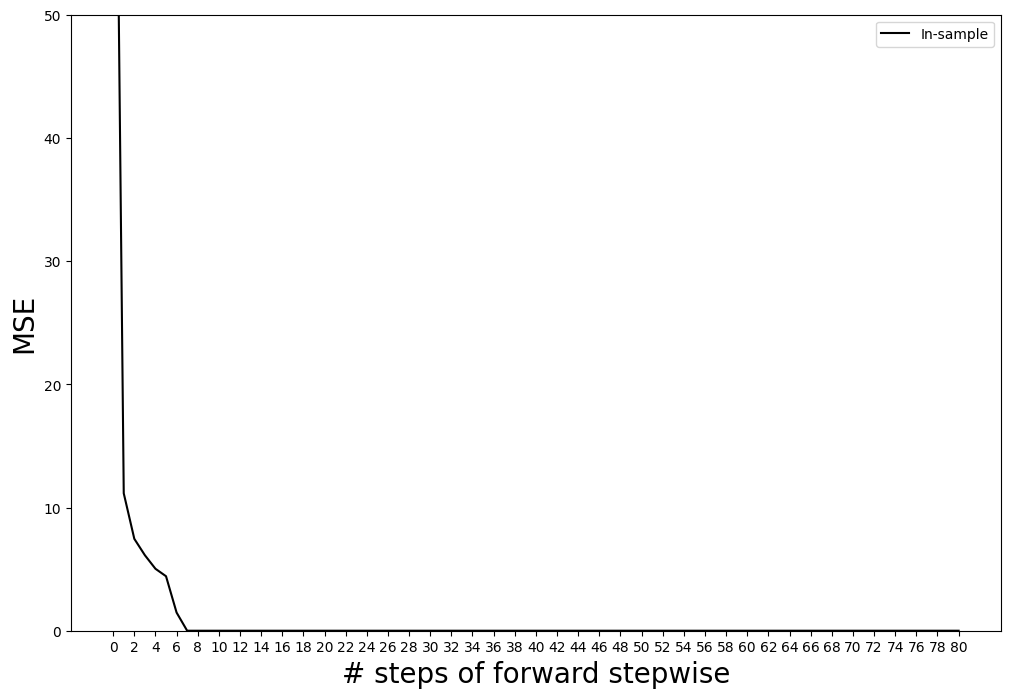

In [33]:
mse_fid, ax = subplots(figsize = (12,8))
insample_mse = ((Yhat_in - Y[:, None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'k', 
        label = 'In-sample')
ax.set_ylabel('MSE',
               fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
              fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([0,50])

Because the HR are tied so closely to the rest of the stats, using current season stats with out home runs to predict home runs over fits the data, there is too much colinearity I believe. 

$ PA = 1B + 2B + 3B + HR + 